## read data from files netatmo

In [398]:
import numpy as np
#import tensorflow as tf
#from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

from sklearn.model_selection import cross_val_score

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

In [399]:
# supprimer d'abord les deux lignes dans le fichier d'export Neatatmo
index_col="Timestamp"
data1=pd.read_csv('data/Netatmo/CapteurAmbiance1_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col=index_col)
data2=pd.read_csv('data/Netatmo/CapteurAmbiance2_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col=index_col)
data3=pd.read_csv('data/Netatmo/CapteurAmbiance3_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col=index_col)
data4=pd.read_csv('data/Netatmo/CapteurAmbiance4_02_03_2022.csv', sep=";", encoding = "ISO-8859-1", parse_dates=["Timezone : Europe/Paris"],index_col=index_col )
#Linky=pd.read_csv('data/Netatmo/Enedis_Conso_DemiHeure_20210401-20220228.csv', sep=";", encoding = "ISO-8859-1")


In [400]:
data= pd.concat([data1, data2, data3, data4], axis=0)

In [401]:
data.interpolate(method='quadratic', inplace=True)

In [402]:
import pandas as pd
bear_family_df = pd.DataFrame(data)
bear_family_df.isna().sum()

Timezone : Europe/Paris    0
Temperature                0
Humidity                   0
CO2                        0
Noise                      0
Pressure                   0
dtype: int64

In [403]:
# EDA : describe data quickly by pandas-profiling
## !pip install pandas_profiling   ## si erreur 
from pandas_profiling import ProfileReport
profile=ProfileReport(data, title='Netatmo Air-Quality',html={'style':{'full_width':True}})
profile.to_widgets()

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

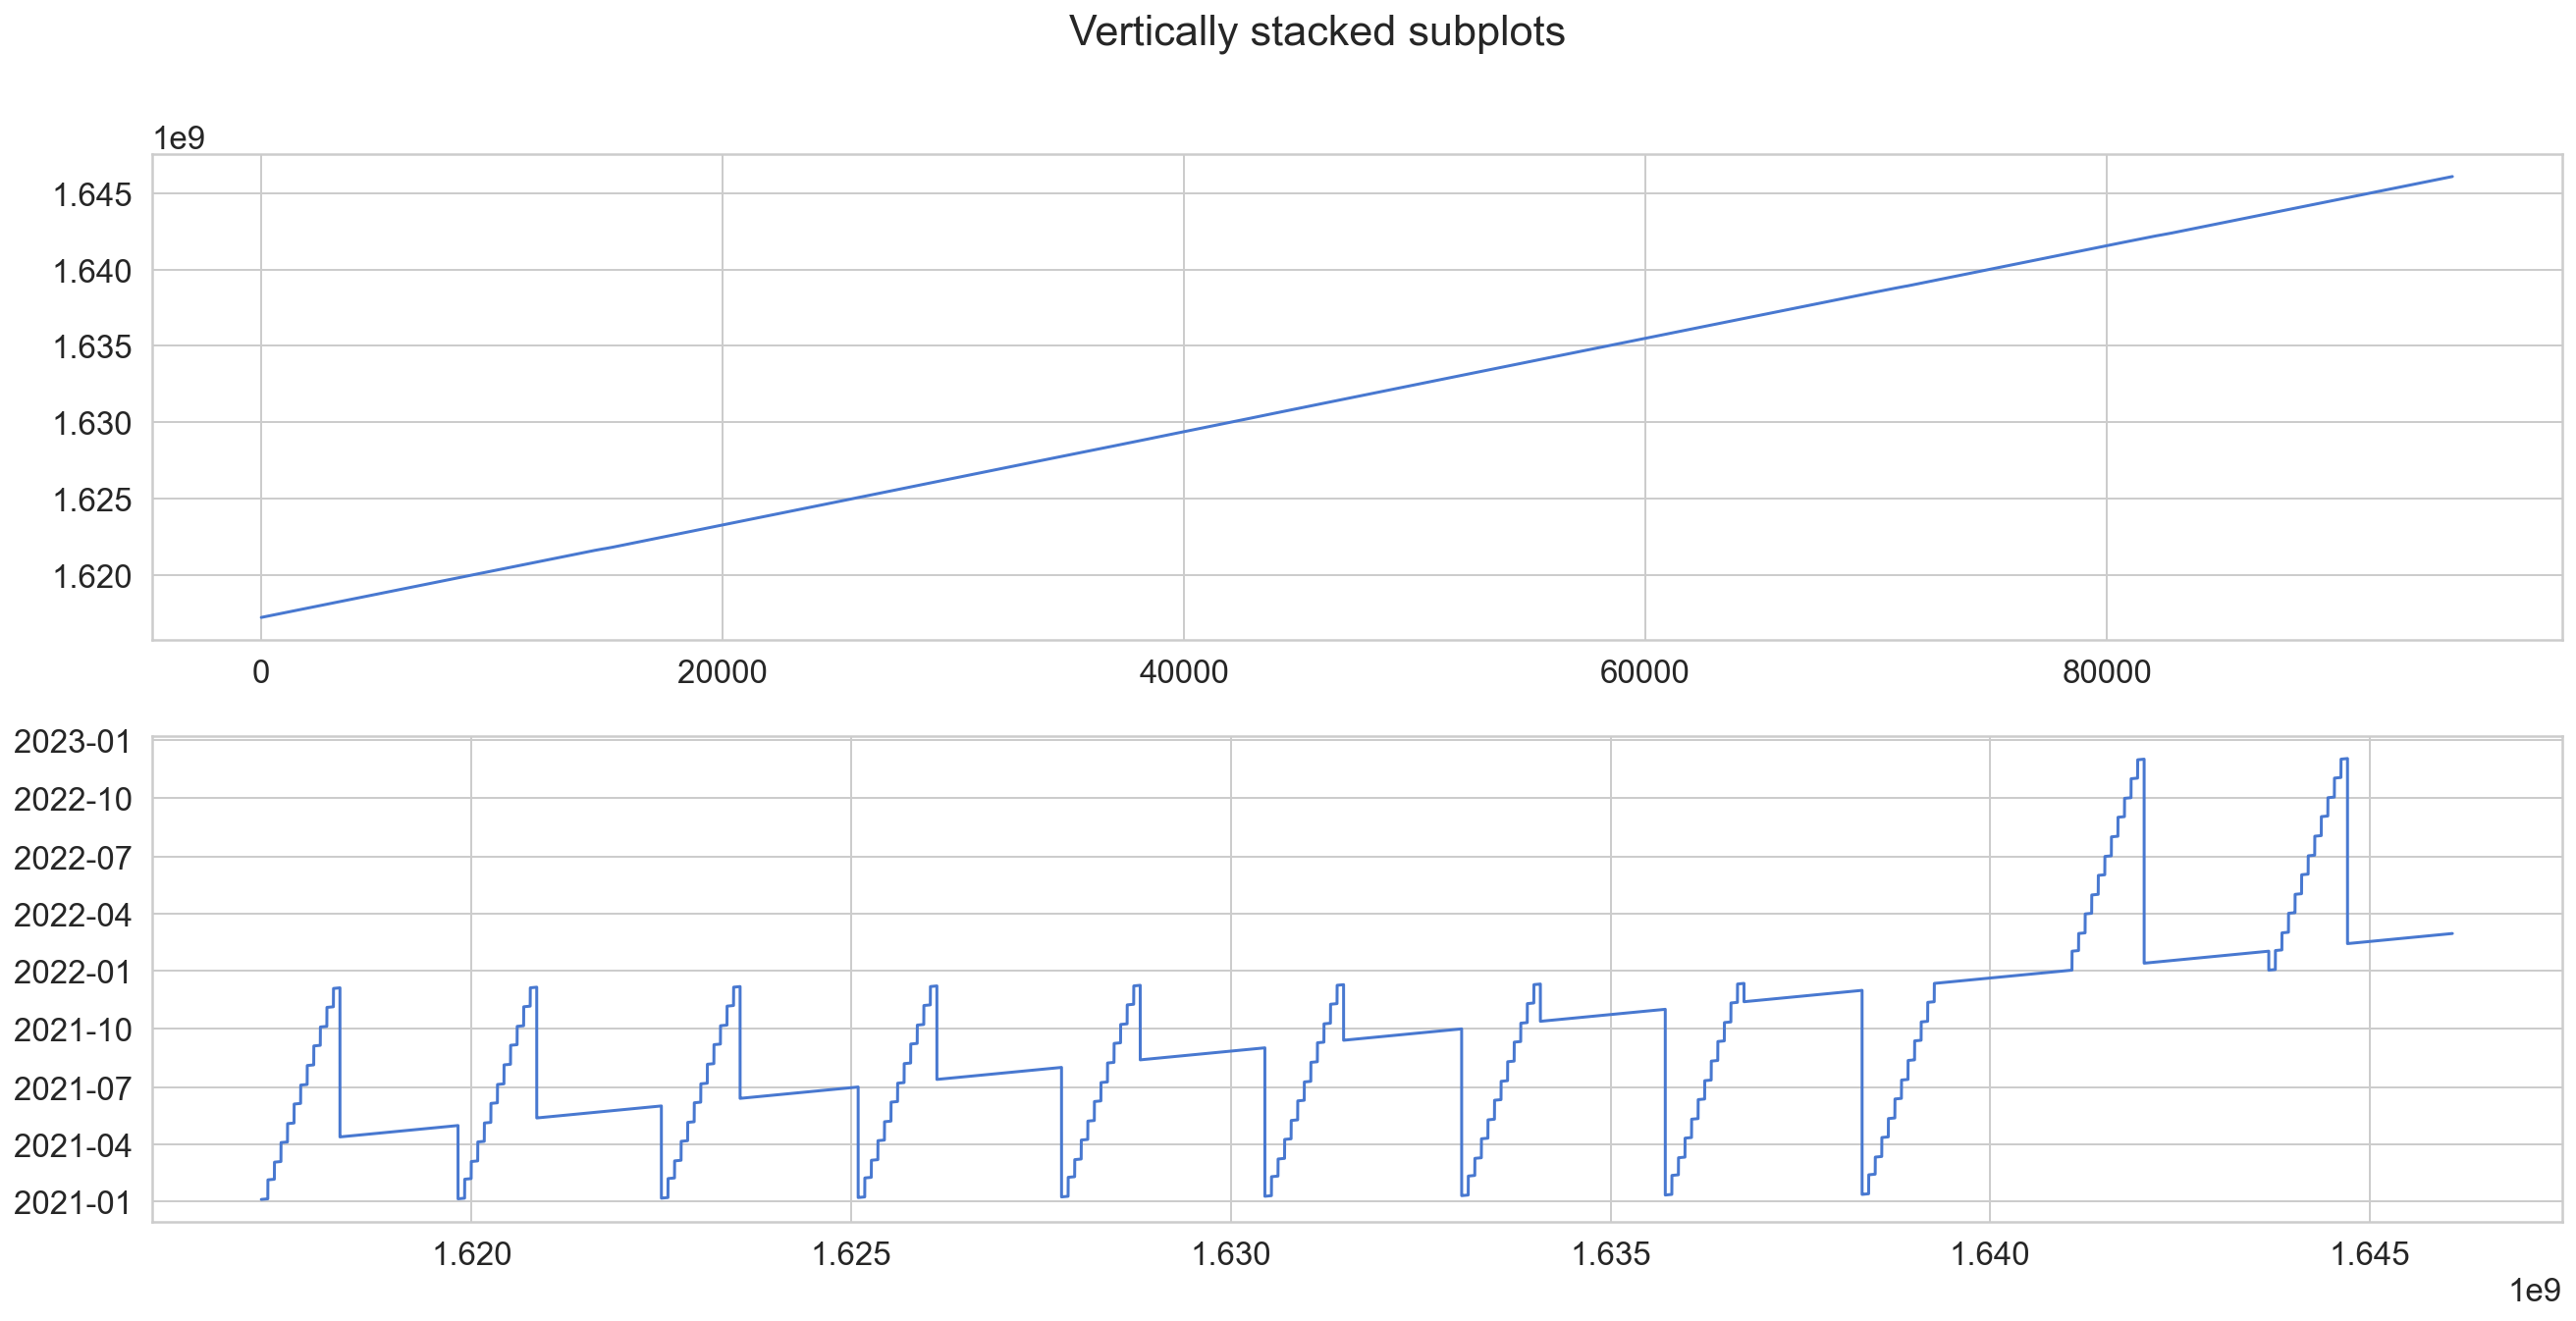

In [404]:
fig, axs = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(data.index)
axs[1].plot(data["Timezone : Europe/Paris"])

In [405]:
#data.to_csv('data.csv') 

## Missing data generation

In [406]:

#!pip install wget 
import wget
#wget.download('https://raw.githubusercontent.com/BorisMuzellec/MissingDataOT/master/utils.py')

import numpy as np
import pandas as pd
from utils import *
import torch
import seaborn as sns

In [407]:
# Fix the seed ------------------------------------------------------
np.random.seed(0)

In [408]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
         For mecha = "MNAR", it indicates how the missing-data mechanism is generated: using a logistic regression ("logistic"), quantile censorship ("quantile") or logistic regression for generating a self-masked MNAR mechanism ("selfmasked").
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
        If mecha = "MNAR" and opt = "quanti", quantile level at which the cuts should occur.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

In [409]:
X = data.copy()
X = X.drop(["Timezone : Europe/Paris"], axis=1)
X = X.values


In [410]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
datascaler=scaler.fit(X)
X= datascaler.transform(X)

In [411]:
# Minimal example for generating missing data ------------------------
X_miss_mcar = produce_NA(X, p_miss=0.4, mecha="MCAR")

X_mcar = X_miss_mcar['X_incomp']
R_mcar = X_miss_mcar['mask']

print("Percentage of newly generated missing values: ", (R_mcar.sum()).numpy()/np.prod(R_mcar.size())*100, " %")

Percentage of newly generated missing values:  40.15582555960327  %


In [412]:
df = X_mcar
df = df.numpy()

In [415]:
df = pd.DataFrame(data=df, columns=['Temperature', 'Humidity', 'CO2', 'Noise','Pressure'])

In [416]:
df['Timestamp']= data.index
df.set_index('Timestamp',inplace = True)


In [417]:
df.head()

,Temperature,Humidity,CO2,Noise,Pressure
Timestamp,,,,,
1617228022,0.537645,-0.183868,NaN,-0.488016,-0.026767
1617228324,NaN,-0.183868,0.364470,-0.488016,-0.014863
1617228626,NaN,-0.183868,0.450638,NaN,NaN
1617228929,NaN,-0.183868,0.364470,NaN,-0.026767
1617229232,0.506075,NaN,0.364470,-0.488016,NaN


## Time Series Imputation Techniques

In [235]:
### Forward Fill
# Impute airquality DataFrame with ffill method
columnNam= 'Noise'
a, taille=100,500

ffill_imputed = df.copy(deep=True)
ffill_imputed.fillna(method='ffill',inplace=True)
ffill_imputed.fillna(method='bfill',inplace=True)

bfill_imputed = df.copy(deep=True)
bfill_imputed.fillna(method='bfill',inplace=True)
bfill_imputed.fillna(method='ffill',inplace=True)

quadratic_imput=df.copy(deep=True)
quadratic_imput.interpolate(method='quadratic', inplace=True)
quadratic_imput.fillna(method='ffill',inplace=True)
quadratic_imput.fillna(method='bfill',inplace=True)


nearest_imput=df.copy(deep=True)
nearest_imput=nearest_imput.interpolate(method='nearest', inplace=True)

linear_imput=df.copy(deep=True)
linear_imput.interpolate(method='linear', inplace=True)
linear_imput.fillna(method='ffill',inplace=True)
linear_imput.fillna(method='bfill',inplace=True)


In [236]:
import pandas as pd
bear_family_df = pd.DataFrame(X)
bear_family_df.isna().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [252]:
#quadratic_imput
df.columns


Index(['Temperature', 'Humidity', 'CO2', 'Noise', 'Pressure'], dtype='object')

In [457]:
Xarima=pd.read_csv('df40MCAR.csv', sep=",", encoding = "ISO-8859-1")
Xarimaimputed=pd.read_csv('kalmanArimafalse2.csv', sep=",", encoding = "ISO-8859-1")

In [458]:
Xarimaimputed=Xarimaimputed.set_index('Timestamp')

In [459]:
Ximp= Xarimaimputed.values

for i in range(5):
    print("kalmanArimafalse2", "  "+str(df.columns[i]), RMSE(Ximp[:,i], X[:,i], mask[:,i]))
print("kalmanArimafalse2", " all ", RMSE(Ximp, X, mask))
   

kalmanArimafalse2   Temperature tensor(0.0150)
kalmanArimafalse2   Humidity tensor(0.0240)
kalmanArimafalse2   CO2 tensor(0.1017)
kalmanArimafalse2   Noise tensor(0.3416)
kalmanArimafalse2   Pressure tensor(0.0091)
kalmanArimafalse2  all  tensor(0.1599)


In [439]:
df.head(10)

,Temperature,Humidity,CO2,Noise,Pressure
Timestamp,,,,,
1617228022,0.537645,-0.183868,NaN,-0.488016,-0.026767
1617228324,NaN,-0.183868,0.364470,-0.488016,-0.014863
1617228626,NaN,-0.183868,0.450638,NaN,NaN
1617228929,NaN,-0.183868,0.364470,NaN,-0.026767
1617229232,0.506075,NaN,0.364470,-0.488016,NaN
1617229535,0.506075,NaN,0.283371,-0.488016,NaN
1617229838,0.506075,-0.318494,0.475981,NaN,NaN
1617230140,0.506075,NaN,0.283371,-0.488016,-0.014863
1617230443,0.506075,-0.318494,0.328989,NaN,NaN


In [440]:
Xarima.head(10)

,Timestamp,Temperature,Humidity,CO2,Noise,Pressure
0,1617228022,0.537645,-0.183868,NaN,-0.488016,-0.026767
1,1617228324,NaN,-0.183868,0.364470,-0.488016,-0.014863
2,1617228626,NaN,-0.183868,0.450638,NaN,NaN
3,1617228929,NaN,-0.183868,0.364470,NaN,-0.026767
4,1617229232,0.506075,NaN,0.364470,-0.488016,NaN
5,1617229535,0.506075,NaN,0.283371,-0.488016,NaN
6,1617229838,0.506075,-0.318494,0.475981,NaN,NaN
7,1617230140,0.506075,NaN,0.283371,-0.488016,-0.014863
8,1617230443,0.506075,-0.318494,0.328989,NaN,NaN
9,1617230746,0.506075,NaN,0.258028,-0.488016,-0.014863


In [257]:
# Create a dictionary of interpolations
interpolations = {'Back-fill':bfill_imputed, 'Forward-fill':ffill_imputed,
                  'Linear Interpolation': linear_imput, 'Quadratic Interpolation': quadratic_imput, 'KNN': KNNimputed}
mask = R_mcar

n_neighbors=4

# Loop over axes and interpolations
print("KNN K= ", n_neighbors)
for df_key in  interpolations:
    if df_key == 'KNN' :
        Ximp = interpolations[df_key]
    else :
        Ximp = interpolations[df_key].values
        
    for i in range(5):
        print(df_key, "  "+str(df.columns[i]), RMSE(Ximp[:,i], X[:,i], mask[:,i]))
        
    print(df_key, " all ", RMSE(Ximp, X, mask))  


KNN K=  4
Back-fill   Temperature tensor(0.0243)
Back-fill   Humidity tensor(0.0375)
Back-fill   CO2 tensor(0.1983)
Back-fill   Noise tensor(0.5608)
Back-fill   Pressure tensor(0.0140)
Back-fill  all  tensor(0.2669)
Forward-fill   Temperature tensor(0.0237)
Forward-fill   Humidity tensor(0.0385)
Forward-fill   CO2 tensor(0.1484)
Forward-fill   Noise tensor(0.5402)
Forward-fill   Pressure tensor(0.0142)
Forward-fill  all  tensor(0.2514)
Linear Interpolation   Temperature tensor(0.0141)
Linear Interpolation   Humidity tensor(0.0250)
Linear Interpolation   CO2 tensor(0.1032)
Linear Interpolation   Noise tensor(0.4177)
Linear Interpolation   Pressure tensor(0.0086)
Linear Interpolation  all  tensor(0.1929)
Quadratic Interpolation   Temperature tensor(0.0267)
Quadratic Interpolation   Humidity tensor(0.0314)
Quadratic Interpolation   CO2 tensor(0.1318)
Quadratic Interpolation   Noise tensor(0.7546)
Quadratic Interpolation   Pressure tensor(0.0124)
Quadratic Interpolation  all  tensor(0.3430

array([[ 0.53764529, -0.18386842,  0.44050034, -0.48801638, -0.02676731],
       [ 0.50607515, -0.18386842,  0.36447013, -0.48801638, -0.01486273],
       [ 0.50607515, -0.18386842,  0.4506377 , -0.48801638, -0.01486273],
       ...,
       [-0.53573934, -0.99162003,  0.74462116, -0.48801638,  0.87798036],
       [-0.53573934, -0.99162003,  0.63817887, -0.48801638,  0.86607579],
       [-0.53573934, -0.99162003,  0.61283547, -0.48801638,  0.86607579]])

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer
X1 = df.copy()
for k in np.arange(1500,10000,500):
    imputer = KNNImputer(n_neighbors=k)
    KNNimputed = imputer.fit_transform(X1)
    Ximp= KNNimputed
    print("k = ",k)
    for i in range(5):
        print(df_key, "  "+str(df.columns[i]), RMSE(Ximp[:,i], X[:,i], mask[:,i]))
    print(df_key, " all ", RMSE(Ximp, X, mask))

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# Setting the random_state argument for reproducibility
imputer = IterativeImputer(random_state=42)
imputed = imputer.fit_transform(df)
df_imputed = pd.DataFrame(imputed, columns=df.columns)
df_key="IterativeImputer"
round(df_imputed, 2)


In [362]:
Ximp= y_hat.values
print("k = ",k)
for i in range(5):
    print(df_key, "  "+str(df.columns[i]), RMSE(Ximp[:,i], X[:,i], mask[:,i]))
print(df_key, " all ", RMSE(Ximp, X, mask))    

k =  1500


IndexError: boolean index did not match indexed array along dimension 0; dimension is 96192 but corresponding boolean dimension is 94978

In [363]:
y.shape

(96192, 5)

In [365]:
data.shape

(94978, 6)

In [396]:
from sktime.transformations.series.impute import Imputer
from sktime.datasets import load_airline
y = df.copy()
print(y.shape)
import datetime

# current date and time

i=0
a=[]

for t in y.index:
    a.append(datetime.datetime.fromtimestamp(t))
    
y.index=a
print(y.shape)
y = y.sort_index()
print(y.shape)
y=y.resample("604S").mean()
print(y.shape)
transformer = Imputer(method="drift")
y_hat = transformer.fit_transform(y)

(94978, 5)
(94978, 5)
(94978, 5)
(47778, 5)


In [367]:
96192-94978

1214

In [343]:
import datetime

# current date and time

i=0
a=[]

for t in y.index:
    a.append(datetime.datetime.fromtimestamp(t))     


In [355]:
y=y.resample("5T").mean()

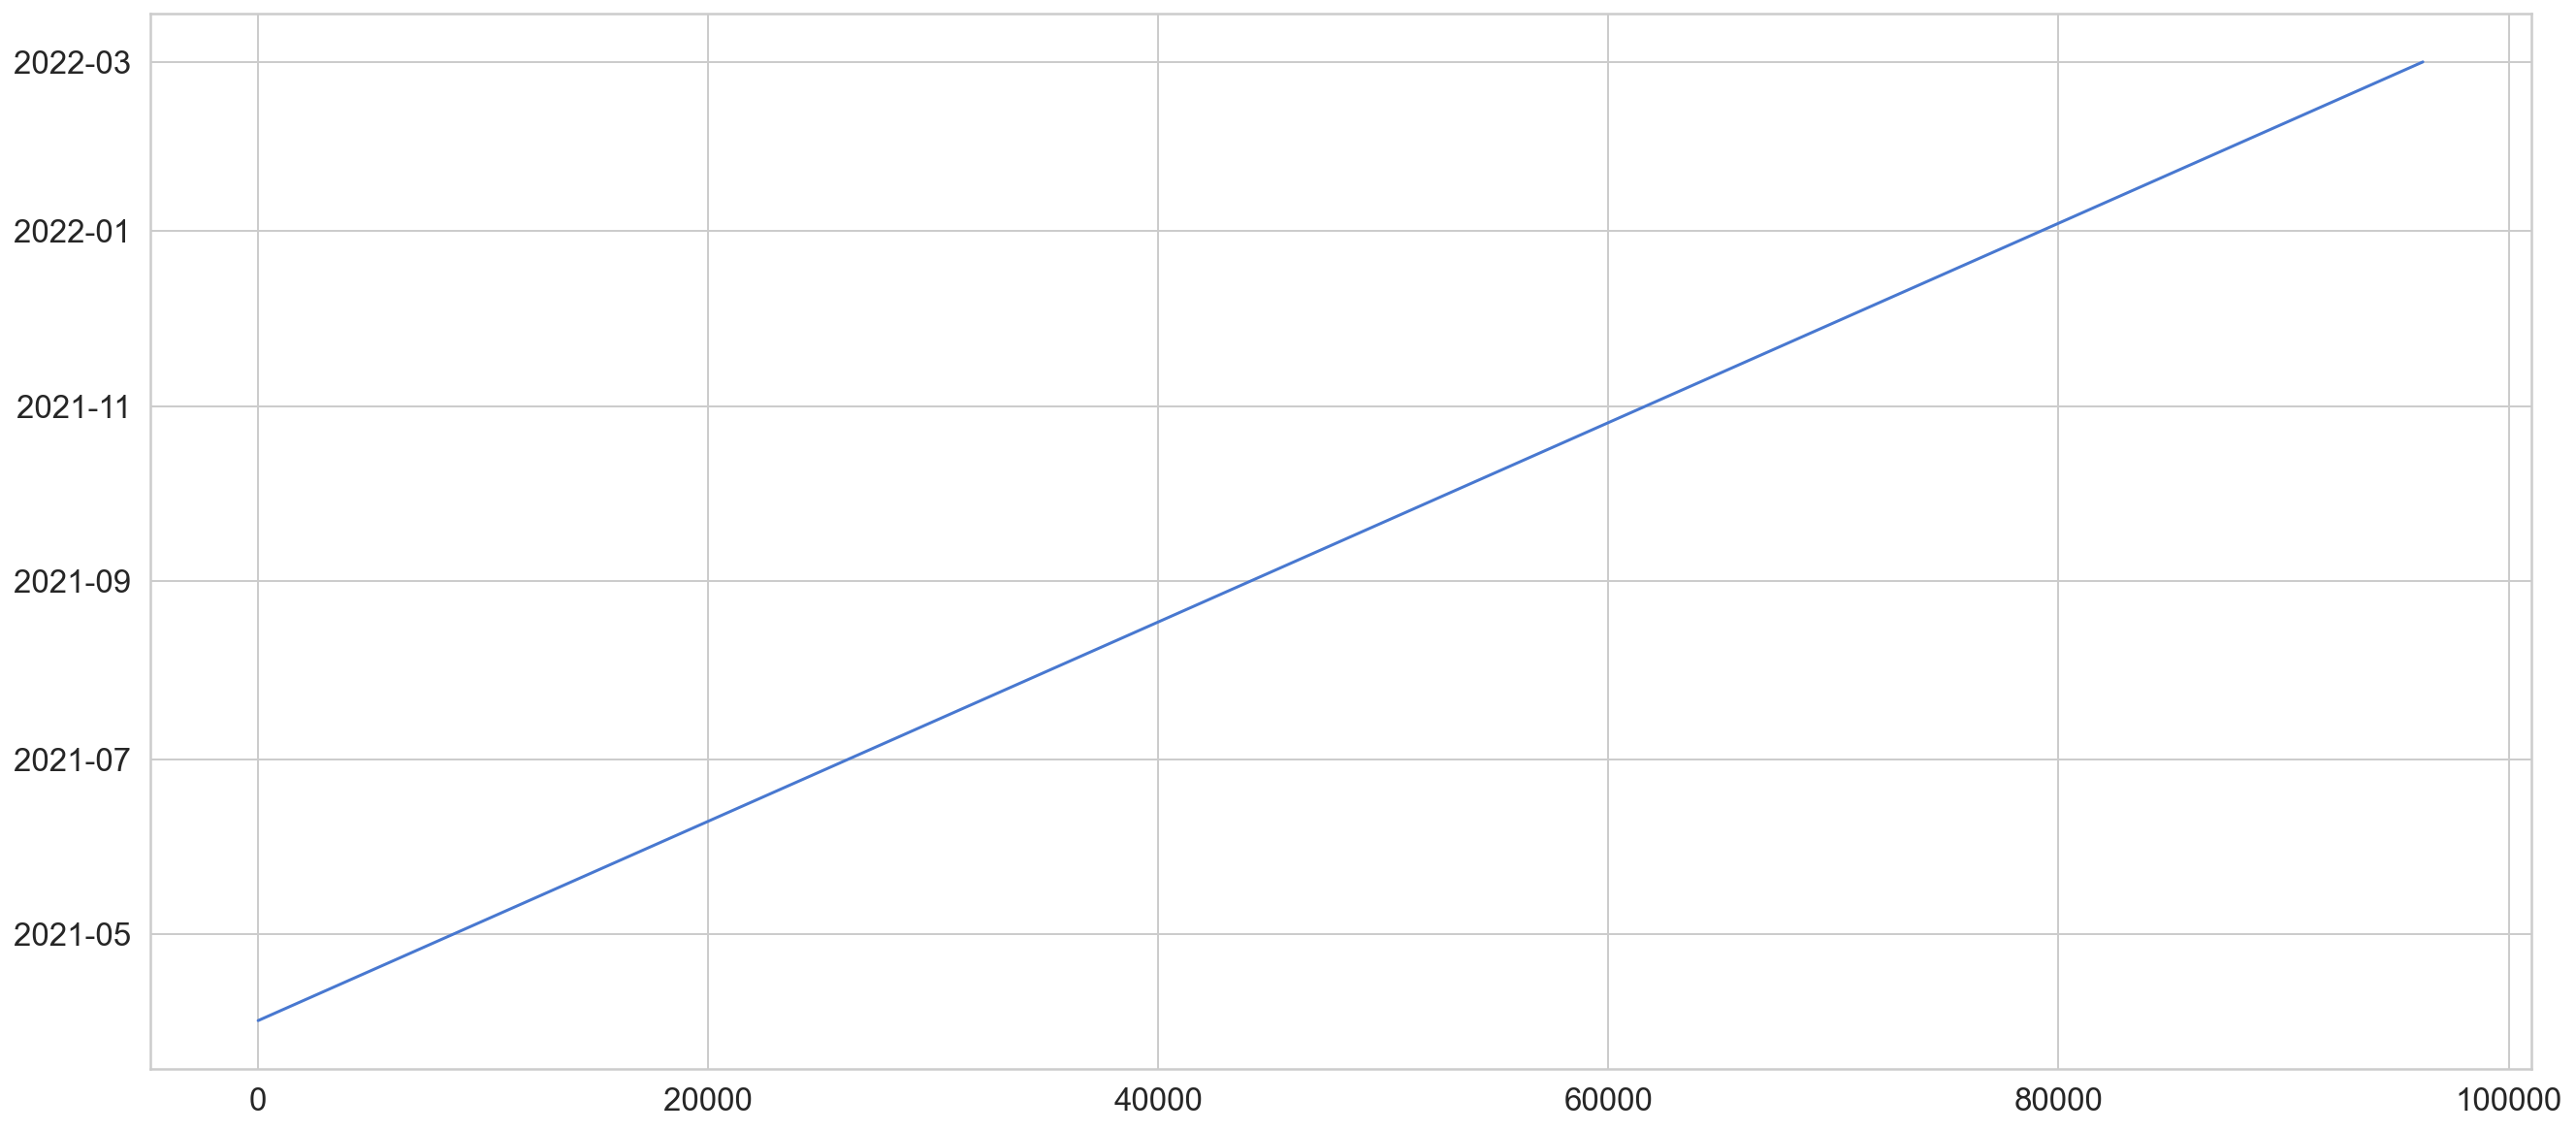

In [356]:
plt.plot(y.index)

In [342]:
a

array([18.,  0.,  0.,  0.,  0.])

In [327]:
t

1617228022

In [141]:
#visualize data 

# Import missingno as msno
import missingno as msno
import matplotlib.pyplot as plt

# Plot amount of missingness
msno.bar(X) # you can see pandas-profilin count part

plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

In [ ]:
dfX_fuul = pd.DataFrame(data=X_full,columns=["c1", "c2","c3", "c4","c5", "c6","c7", "c8"])

In [ ]:
dfX_fuul.info()

In [ ]:
X.loc[columnNam]

In [ ]:
columnNam

In [ ]:
X[:,0]

In [ ]:
df.Temperature

In [ ]:
R_mcar

In [ ]:
df.columns

In [ ]:
# mask pour évaluer les performances (mse,rmse, nrmse..)
m=R_mcar.numpy()
mk=m==1

maskPerf_Temperature = mk[:,0]
maskPerf_Humidity = mk[:,1]
maskPerf_CO2 = mk[:,2]
maskPerf_Noise = mk[:,3]
maskPerf_Pressure = mk[:,4]

In [ ]:
df

In [ ]:
df.Temperature[maskPerf_Temperature]

In [ ]:
data.Temperature[maskPerf_Temperature]

In [ ]:
from sklearn.metrics import mean_squared_error

y_true = X[maskmse][:,0]
y_pred =X_imp[maskmse][:,3]
mean_squared_error(y_true, y_pred)

## Imputation des valeurs manquantes avec des variantes d’IterativeImputer
# https://scikit-learn.org/stable/auto_examples/impute/plot_iterative_imputer_variants_comparison.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.datasets import fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

N_SPLITS = 5

rng = np.random.RandomState(0)

X_full, y_full = fetch_california_housing(return_X_y=True)
# ~2k samples is enough for the purpose of the example.
# Remove the following two lines for a slower run with different error bars.
X_full = X_full[::10]
y_full = y_full[::10]
n_samples, n_features = X_full.shape

# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

# Add a single missing value to each row
X_missing = X_full.copy()
y_missing = y_full
missing_samples = np.arange(n_samples)
missing_features = rng.choice(n_features, n_samples, replace=True)
X_missing[missing_samples, missing_features] = np.nan

# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features="sqrt", random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()
for impute_estimator in estimators:
    estimator = make_pipeline(
        IterativeImputer(random_state=0, estimator=impute_estimator), br_estimator
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)

# plot california housing results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("California Housing Regression with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

In [460]:
!pip install impyute

In [463]:
import impyute as impy
df1=df.copy()

In [ ]:
df2=impy.mice(df1.values)